In [1]:
using QuantumCumulants
using SymbolicUtils
using IterTools
using Symbolics
using Revise
using QuantumGraining
using OrdinaryDiffEq
using ModelingToolkit

In [2]:
# include("../src/diagrams.jl")
# include("../src/bvector.jl")
# include("../src/bubble.jl")
# include("../src/diagram.jl")
# include("../src/poles.jl")
# include("../src/contractions.jl")
# include("../src/printing.jl")
# include("../src/corrections.jl")
# include("../src/lindblad.jl")

## Setting up the Hilbert space and operators

In [3]:
# Setup
h_cav = FockSpace(:cavity)
h_atom = NLevelSpace(:atom, (:g,:e))
h = tensor(h_cav, h_atom)

@qnumbers a::Destroy(h) σ::Transition(h)

#@syms ω_0 ω_d g κ γ ϵ ω_3 ω_1
#@variables ω_c::real ω_a::real
#@variables t::Real

σz = 2* σ(:e, :e)  - 1
σx = σ(:g, :e) + σ(:e, :g)
σy = 1im* (σ(:e, :g) - σ(:g, :e))


(0 + 1im*(σeg)+0 - 1im*(σge))

## Studying the Rabi model

### First order approximation using the TCG algorithm

In [4]:
@variables ω_c ω_a 

ωs_rabi = [ω_c + ω_a, -ω_c - ω_a, -ω_c + ω_a, ω_c - ω_a]
hs_rabi = [a*σ(:e, :g),a'*σ(:g, :e),a*σ(:g, :e), a'*σ(:e, :g)]

eff_ham_rabi_1, ops_eff_rabi_1, ωs_eff_rabi_1, gs_eff_rabi_1 = effective_hamiltonian(hs_rabi, ωs_rabi, 1)

(Any[], Any[(a*σeg), (a′*σge), (a*σge), (a′*σeg)], Any[Any[ω_a + ω_c], Any[-ω_a - ω_c], Any[ω_a - ω_c], Any[ω_c - ω_a]], Any[exp(-0.5(τ^2)*((ω_a + ω_c)^2)), exp(-0.5(τ^2)*((-ω_a - ω_c)^2)), exp(-0.5(τ^2)*((ω_a - ω_c)^2)), exp(-0.5(τ^2)*((ω_c - ω_a)^2))])

In [5]:
ops_eff_rabi_1

4-element Vector{Any}:
 (a*σeg)
 (a′*σge)
 (a*σge)
 (a′*σeg)

Note that the elements of `ωs_eff_rabi_1` are vectors, and not frequencies.

In [6]:
ωs_eff_rabi_1

4-element Vector{Any}:
 Any[ω_a + ω_c]
 Any[-ω_a - ω_c]
 Any[ω_a - ω_c]
 Any[ω_c - ω_a]

To fix that, we use `vcat()`

In [7]:
ωs_eff_rabi_1 = vcat(ωs_eff_rabi_1...)

4-element Vector{Any}:
  ω_a + ω_c
 -ω_a - ω_c
  ω_a - ω_c
  ω_c - ω_a

In [8]:
gs_eff_rabi_1

4-element Vector{Any}:
 exp(-0.5(τ^2)*((ω_a + ω_c)^2))
 exp(-0.5(τ^2)*((-ω_a - ω_c)^2))
 exp(-0.5(τ^2)*((ω_a - ω_c)^2))
 exp(-0.5(τ^2)*((ω_c - ω_a)^2))

It is useful to look at the symbolic expression

In [9]:
@cnumbers τ
g_eff_1_sym = to_symbol.(gs_eff_rabi_1, τ)

4-element Vector{Num}:
 exp(-0.5(τ^2)*((ω_a + ω_c)^2))
 exp(-0.5(τ^2)*((-ω_a - ω_c)^2))
 exp(-0.5(τ^2)*((ω_a - ω_c)^2))
 exp(-0.5(τ^2)*((ω_c - ω_a)^2))

In [10]:
@syms t::Real
H_eff_1_sym = ops_eff_rabi_1.*g_eff_1_sym.*exp.(-im*t*ωs_eff_rabi_1)

4-element Vector{QuantumCumulants.QMul{Nothing}}:
 exp(-0.5(τ^2)*((ω_a + ω_c)^2))*exp((0 - 1im)*t*(ω_a + ω_c))*(a*σeg)
 exp(-0.5(τ^2)*((-ω_a - ω_c)^2))*exp((0 - 1im)*t*(-ω_a - ω_c))*(a′*σge)
 exp(-0.5(τ^2)*((ω_a - ω_c)^2))*exp((0 - 1im)*t*(ω_a - ω_c))*(a*σge)
 exp(-0.5(τ^2)*((ω_c - ω_a)^2))*exp((0 - 1im)*t*(ω_c - ω_a))*(a′*σeg)

### Solving the model

We start by replacing the variables with `QuantumCumulants.jl` variables,

In [11]:
@cnumbers ω1 ω2 

subs = Dict(
    ω_a => ω1, 
    ω_c => ω2
)
H_eff_qc = [substitute(h, subs) for h in H_eff_1_sym]

4-element Vector{QuantumCumulants.QMul{Nothing}}:
 exp((0 - 1im)*t*(ω1 + ω2))*exp(-0.5(τ^2)*((ω1 + ω2)^2))*(a*σeg)
 exp((0 - 1im)*t*(-ω1 - ω2))*exp(-0.5(τ^2)*((-ω1 - ω2)^2))*(a′*σge)
 exp((0 - 1im)*t*(ω1 - ω2))*exp(-0.5(τ^2)*((ω1 - ω2)^2))*(a*σge)
 exp((0 - 1im)*t*(ω2 - ω1))*exp(-0.5(τ^2)*((ω2 - ω1)^2))*(a′*σeg)

In [12]:
H_sum = sum(H_eff_qc)

(exp((0 - 1im)*t*(ω1 + ω2))*exp(-0.5(τ^2)*((ω1 + ω2)^2))*(a*σeg)+exp((0 - 1im)*t*(-ω1 - ω2))*exp(-0.5(τ^2)*((-ω1 - ω2)^2))*(a′*σge)+exp((0 - 1im)*t*(ω1 - ω2))*exp(-0.5(τ^2)*((ω1 - ω2)^2))*(a*σge)+exp((0 - 1im)*t*(ω2 - ω1))*exp(-0.5(τ^2)*((ω2 - ω1)^2))*(a′*σeg))

In [13]:
typeof(H_sum)

QuantumCumulants.QAdd

Weirdly, this gives an error when we try to use that together with `QuantumCumulants.jl`

In [14]:
eqs = meanfield([a, σ(:e, :e)], H_sum, []; rates=[], order=2, iv=t)
eqs = complete(eqs)

∂ₜ(⟨a⟩) = (0 - 1im)*⟨σeg⟩*exp((0 - 1im)*t*(ω2 - ω1) - 0.5(τ^2)*((ω2 - ω1)^2)) + (0 - 1im)*⟨σge⟩*exp((0 - 1im)*t*(-ω1 - ω2) - 0.5(τ^2)*((-ω1 - ω2)^2))
∂ₜ(⟨σee⟩) = (0 - 1im)*exp((0 - 1im)*t*(ω1 + ω2) - 0.5(τ^2)*((ω1 + ω2)^2))*⟨a*σeg⟩ + (0 + 1im)*exp((0 - 1im)*t*(ω1 - ω2) - 0.5(τ^2)*((ω1 - ω2)^2))*⟨a*σge⟩ + (0 - 1im)*exp((0 - 1im)*t*(ω2 - ω1) - 0.5(τ^2)*((ω2 - ω1)^2))*⟨a′*σeg⟩ + (0 + 1im)*exp((0 - 1im)*t*(-ω1 - ω2) - 0.5(τ^2)*((-ω1 - ω2)^2))*⟨a′*σge⟩
∂ₜ(⟨σeg⟩) = (0 + 1im)*⟨a⟩*exp((0 - 1im)*t*(ω1 - ω2) - 0.5(τ^2)*((ω1 - ω2)^2)) + (0 + 1im)*⟨a′⟩*exp((0 - 1im)*t*(-ω1 - ω2) - 0.5(τ^2)*((-ω1 - ω2)^2)) + (0 - 2im)*exp((0 - 1im)*t*(ω1 - ω2) - 0.5(τ^2)*((ω1 - ω2)^2))*⟨a*σee⟩ + (0 - 2im)*exp((0 - 1im)*t*(-ω1 - ω2) - 0.5(τ^2)*((-ω1 - ω2)^2))*⟨a′*σee⟩
∂ₜ(⟨a*σeg⟩) = (0 - 2im)*(⟨a⟩*⟨a′*σee⟩ + ⟨a′⟩*⟨a*σee⟩ + ⟨σee⟩*⟨a′*a⟩ - 2⟨a′⟩*⟨a⟩*⟨σee⟩)*exp((0 - 1im)*t*(-ω1 - ω2) - 0.5(τ^2)*((-ω1 - ω2)^2)) + (0 - 2im)*(⟨σee⟩*⟨a*a⟩ + 2⟨a⟩*⟨a*σee⟩ - 2(⟨a⟩^2)*⟨σee⟩)*exp((0 - 1im)*t*(ω1 - ω2) - 0.5(τ^2)*((ω1 - ω2)^2)) +

In [15]:
@named sys = ODESystem(eqs)

Model sys with 8 equations
States (8):
  var"⟨a⟩"(t)
  var"⟨σee⟩"(t)
  var"⟨σeg⟩"(t)
  var"⟨a*σeg⟩"(t)
⋮
Parameters (3):
  τ
  ω2
  ω1

In [22]:
p0 = (ω1=>1, ω2=>1.01, τ=>1)
u0 = ComplexF64[0, 1, 0, 0, 0, 0, 0, 0]

prob = ODEProblem(sys,u0,(0.0, 50), p0)

ODEProblem with uType Vector{ComplexF64} and tType Float64. In-place: true
timespan: (0.0, 50.0)
u0: 8-element Vector{ComplexF64}:
 0.0 + 0.0im
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

In [23]:
sol = solve(prob,RK4())

retcode: Success
Interpolation: 3rd order Hermite
t: 264-element Vector{Float64}:
  0.0
  0.007531170688643022
  0.023823532014024054
  0.04489504339687165
  0.07322006058758947
  0.10871324781193295
  0.1530946946223217
  0.20683000925243894
  0.2704927292481591
  0.34361810996111136
  ⋮
 48.44445408016575
 48.64336206613416
 48.84820427733723
 49.057864522898534
 49.26742545823201
 49.479968548990456
 49.6966181977359
 49.9188656887467
 50.0
u: 264-element Vector{Vector{ComplexF64}}:
 [0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im]
 [0.0 + 0.0im, 0.9999990020349266 - 2.3490928071013308e-26im, 0.0 + 0.0im, 7.561049065401139e-6 - 0.0009989439610856893im, -1.9055940935765315e-11 - 2.505179229924509e-9im, 0.0 + 0.0im, 9.979839393409633e-7 - 2.3490928071013308e-26im, -7.523059481025749e-6 - 3.758348828577164e-8im]
 [0.0 + 0.0im, 0.9999900171618281 + 3.5791970394661075e-25im, 0.0 + 0.0im, 7.564104461599798e-5 - 0.003158358442499437im

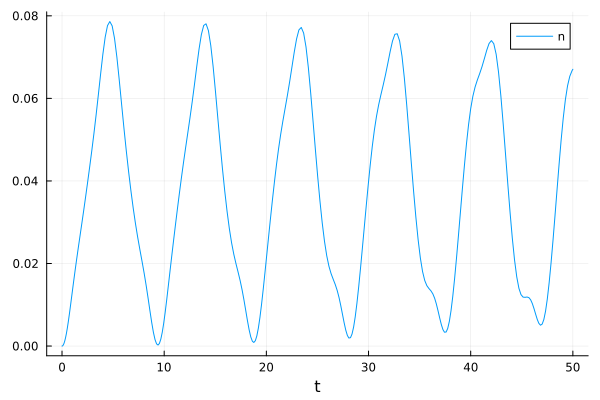

In [24]:
using Plots
n = real.(sol[a'a])
plot(sol.t, n, xlabel="t", label="n")

### Hard-coded Hamiltonian

In [113]:
# H_eff_hc = [exp(-im*t*(ω1 + ω2))*exp(-0.5*τ^2*(ω1 + ω2)^2)*a*σ(:e, :g),
#     exp(-im*t*(-ω1 - ω2))*exp(-0.5*τ^2*(-ω1 - ω2)^2)*a'*σ(:g, :e),
#     exp(-im*t*(-ω1 + ω2))*exp(-0.5*τ^2*(-ω1 + ω2)^2)*a*σ(:g, :e),
#     exp(-im*t*(ω1 - ω2))*exp(-0.5*τ^2*(ω1 - ω2)^2)*a'*σ(:e, :g)]

4-element Vector{QuantumCumulants.QMul{Nothing}}:
 exp((0 - 1im)*t*(ω1 + ω2))*exp(-0.5(τ^2)*((ω1 + ω2)^2))*(a*σeg)
 exp((0 - 1im)*t*(-ω1 - ω2))*exp(-0.5(τ^2)*((-ω1 - ω2)^2))*(a′*σge)
 exp((0 - 1im)*t*(ω2 - ω1))*exp(-0.5(τ^2)*((ω2 - ω1)^2))*(a*σge)
 exp((0 - 1im)*t*(ω1 - ω2))*exp(-0.5(τ^2)*((ω1 - ω2)^2))*(a′*σeg)

In [126]:
# H_sum_hc = sum(H_eff_hc)

(exp((0 - 1im)*t*(ω1 + ω2))*exp(-0.5(τ^2)*((ω1 + ω2)^2))*(a*σeg)+exp((0 - 1im)*t*(-ω1 - ω2))*exp(-0.5(τ^2)*((-ω1 - ω2)^2))*(a′*σge)+exp((0 - 1im)*t*(ω2 - ω1))*exp(-0.5(τ^2)*((ω2 - ω1)^2))*(a*σge)+exp((0 - 1im)*t*(ω1 - ω2))*exp(-0.5(τ^2)*((ω1 - ω2)^2))*(a′*σeg))